In [1]:
#we first import some libraries for the DMD analysis and plot resutls
import warnings
warnings.filterwarnings("ignore")

import os
import xarray as xr
import numpy as np
import scipy

import matplotlib.pyplot as plt
import cartopy.crs as ccrs  #for plot the coastline 
import cartopy.feature as cfeature 

from pydmd.plotter import plot_eigs, plot_summary

#to make sure the kernel you use is from myvenvME5311
import sys
print(sys.executable) 


/home/lc/Desktop/ME5311/myvenvME5311/bin/python


In [2]:
#We load the data and assign it to the X matrix
# dimensions of data
n_samples = 16071
n_lat = 101 
n_lon = 161
shape = (n_samples, n_lat, n_lon)

# load data for slp.nc
ds = xr.open_dataset('project_Data/t2m.nc') # change to 't2m.nc' for temperature data
t2m = ds['t2m'] # 'msl' is the variable name for slp, change to 't2m' for temperature data

# get longitude values
dlongitude = ds['longitude']
lon = dlongitude.values

# get latitude values 
dlatitude = ds['latitude']
lat = dlatitude.values

# mesh for (lo,lat)
lon2d, lat2d = np.meshgrid(lon, lat)

# define reshape (n_lat,n_lon) <-- (n_lat*n_lon,1)
def reshape_mode(mode_vec):
    return mode_vec.reshape(n_lat, n_lon)

# transform it into (n_lat * n_lon, n_samples) from ds (n_samples, n_lat, n_lon)
Xt2m = t2m.values.reshape(t2m.shape[0], -1).T
print(Xt2m.shape)

(16261, 16071)


Singular_values_POD: [70708.93   16963.205   9418.8     8625.5625  7140.234   5763.4126
  5205.2725  4935.8496  4432.0537  4299.0273  3867.3784  3465.442
  3197.7168  3091.2253  2900.1306  2698.9368  2637.47    2450.2085
  2370.0408  2312.0698  2239.4673  2173.979   2102.3994  1976.4746
  1956.4142  1834.4562  1806.8901  1793.4899  1736.1613  1718.7289]


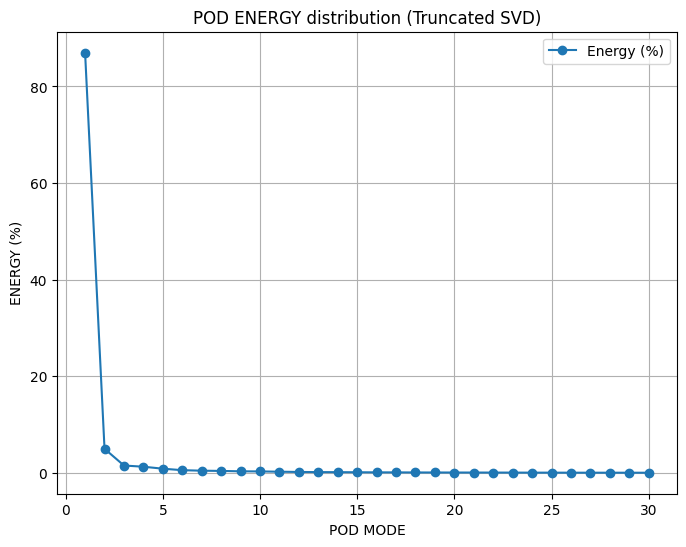

<Figure size 640x480 with 0 Axes>

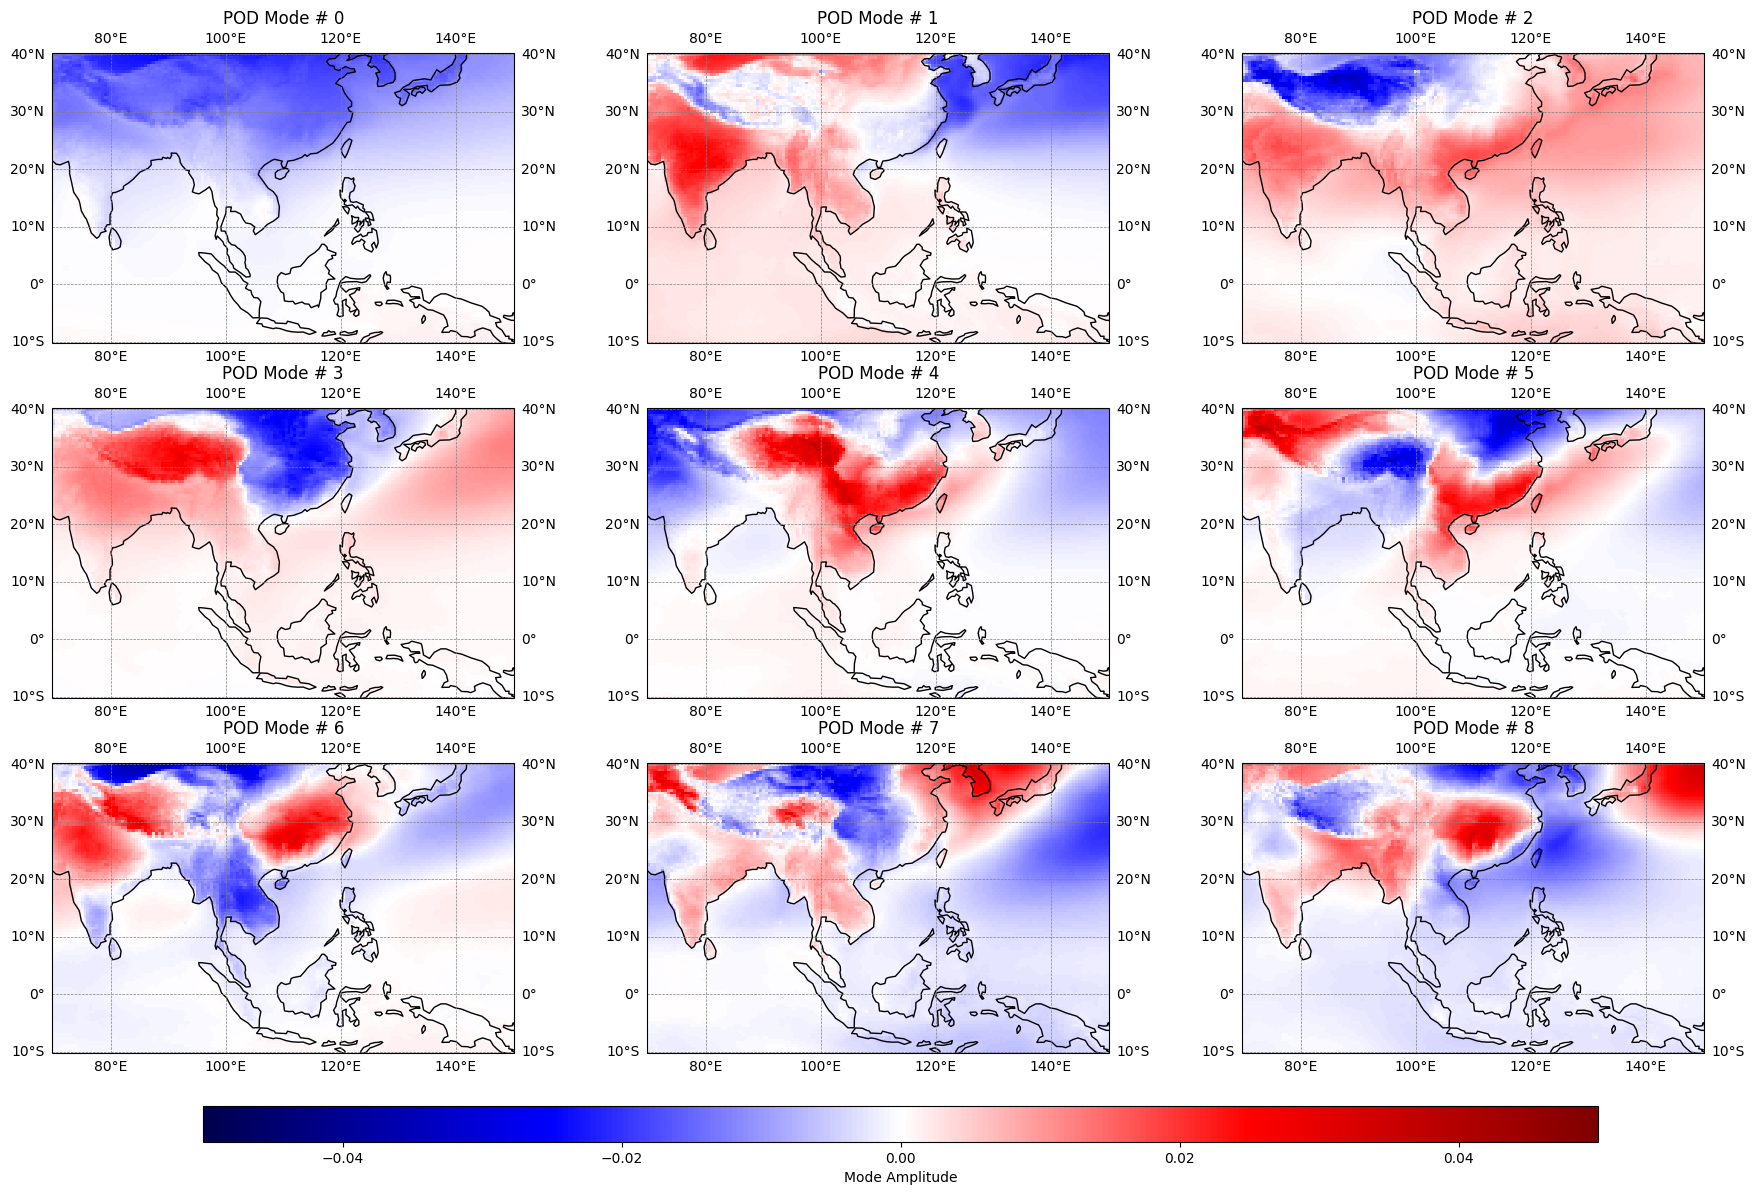

In [3]:
#POD analysis for t2m
from sklearn.decomposition import TruncatedSVD

#first remove mean value
X_mean = np.mean(Xt2m, axis=1, keepdims=True)
Xfluc = Xt2m - X_mean

rPOD = 30  # SVD mode numbers
tsvd = TruncatedSVD(n_components=rPOD, random_state=42)
tsvd.fit(Xfluc)

pod_sing_vals = tsvd.singular_values_
print("Singular_values_POD:", pod_sing_vals)

#V^T: (rPOD, n_smaple)
Vt = tsvd.components_

# U_approx : (n_lat*n_lon, rPOD)
U_approx = Xt2m @ Vt.T @ np.diag(1.0 / pod_sing_vals)

#plot singular values
energy = pod_sing_vals**2
energy_fraction = energy / np.sum(energy)
plt.figure(figsize=(8,6))
plt.plot(np.arange(1, rPOD+1), energy_fraction * 100, 'o-', label='Energy (%)')
plt.xlabel('POD MODE')
plt.ylabel('ENERGY (%)')
plt.title('POD ENERGY distribution (Truncated SVD)')
plt.grid(True)
plt.legend()
plt.show()


#plot mode
plt.figure()
# 0-8 POD mode
plot_mode_n = np.arange(0, 9, 1)
fig, ax = plt.subplots(3, 3, figsize=(18, 12), subplot_kw={'projection': ccrs.PlateCarree()})
# plot extent
extent = [lon.min(), lon.max(), lat.min(), lat.max()]
for i in range(3):
    for j in range(3):
       
        mode_idx = plot_mode_n [ i * 3 + j]
        mode_POD = U_approx[:, mode_idx]       # i th POD mode
        mode_POD_2d = mode_POD.reshape(n_lat, n_lon)  # reshape
        
        #plot POD mode
        im = ax[i, j].pcolormesh(lon2d, lat2d, mode_POD_2d, shading='auto',
                    transform=ccrs.PlateCarree(), cmap='seismic',vmin=-0.05,vmax=0.05)
        
        # coastline
        ax[i, j].coastlines(resolution='110m')
        ax[i, j].add_feature(cfeature.LAND, facecolor='lightgray')
        ax[i, j].add_feature(cfeature.OCEAN, facecolor='lightblue')
        ax[i, j].gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')
        ax[i, j].set_title("POD Mode # {}".format(mode_idx))

# colorbar
cbar_ax = fig.add_axes([0.125, 0.05, 0.775, 0.03])  
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', label='Mode Amplitude')
fig.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()


In [4]:
#We then perform the DMD analysis
#exact DMD and BOPDMD
import time
import numpy as np

from pydmd import DMD,BOPDMD

#exact DMD
start = time.time()
dmd = DMD(svd_rank=20)
dmd.fit(Xt2m)
end = time.time()
print(f"DMD time：{end - start:.6f} second")

#BOP DMD
t = np.arange(Xt2m.shape[1])
start = time.time()
BOPdmd = BOPDMD(svd_rank=20,num_trials=0)
BOPdmd.fit(Xt2m,t)
end = time.time()
print(f"BOPDMD time：{end - start:.6f} second")

>>> I AM USING THE MODIFIED FUNCTION for randomized_svd!
DMD time：73.334105 second
>>> I AM USING THE MODIFIED FUNCTION for randomized_svd!
>>> I AM USING THE MODIFIED FUNCTION for randomized_svd!
BOPDMD time：643.617192 second


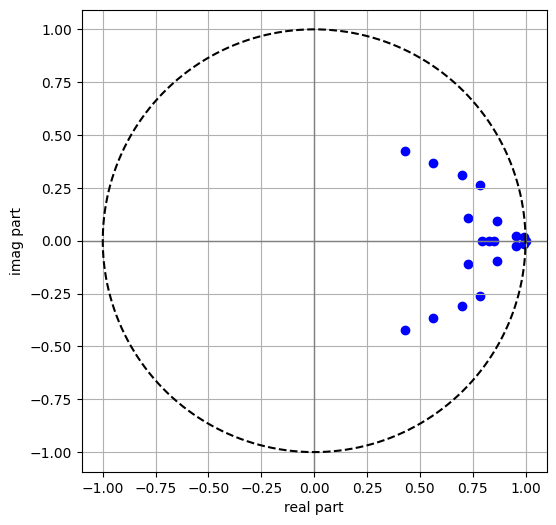

<Figure size 640x480 with 0 Axes>

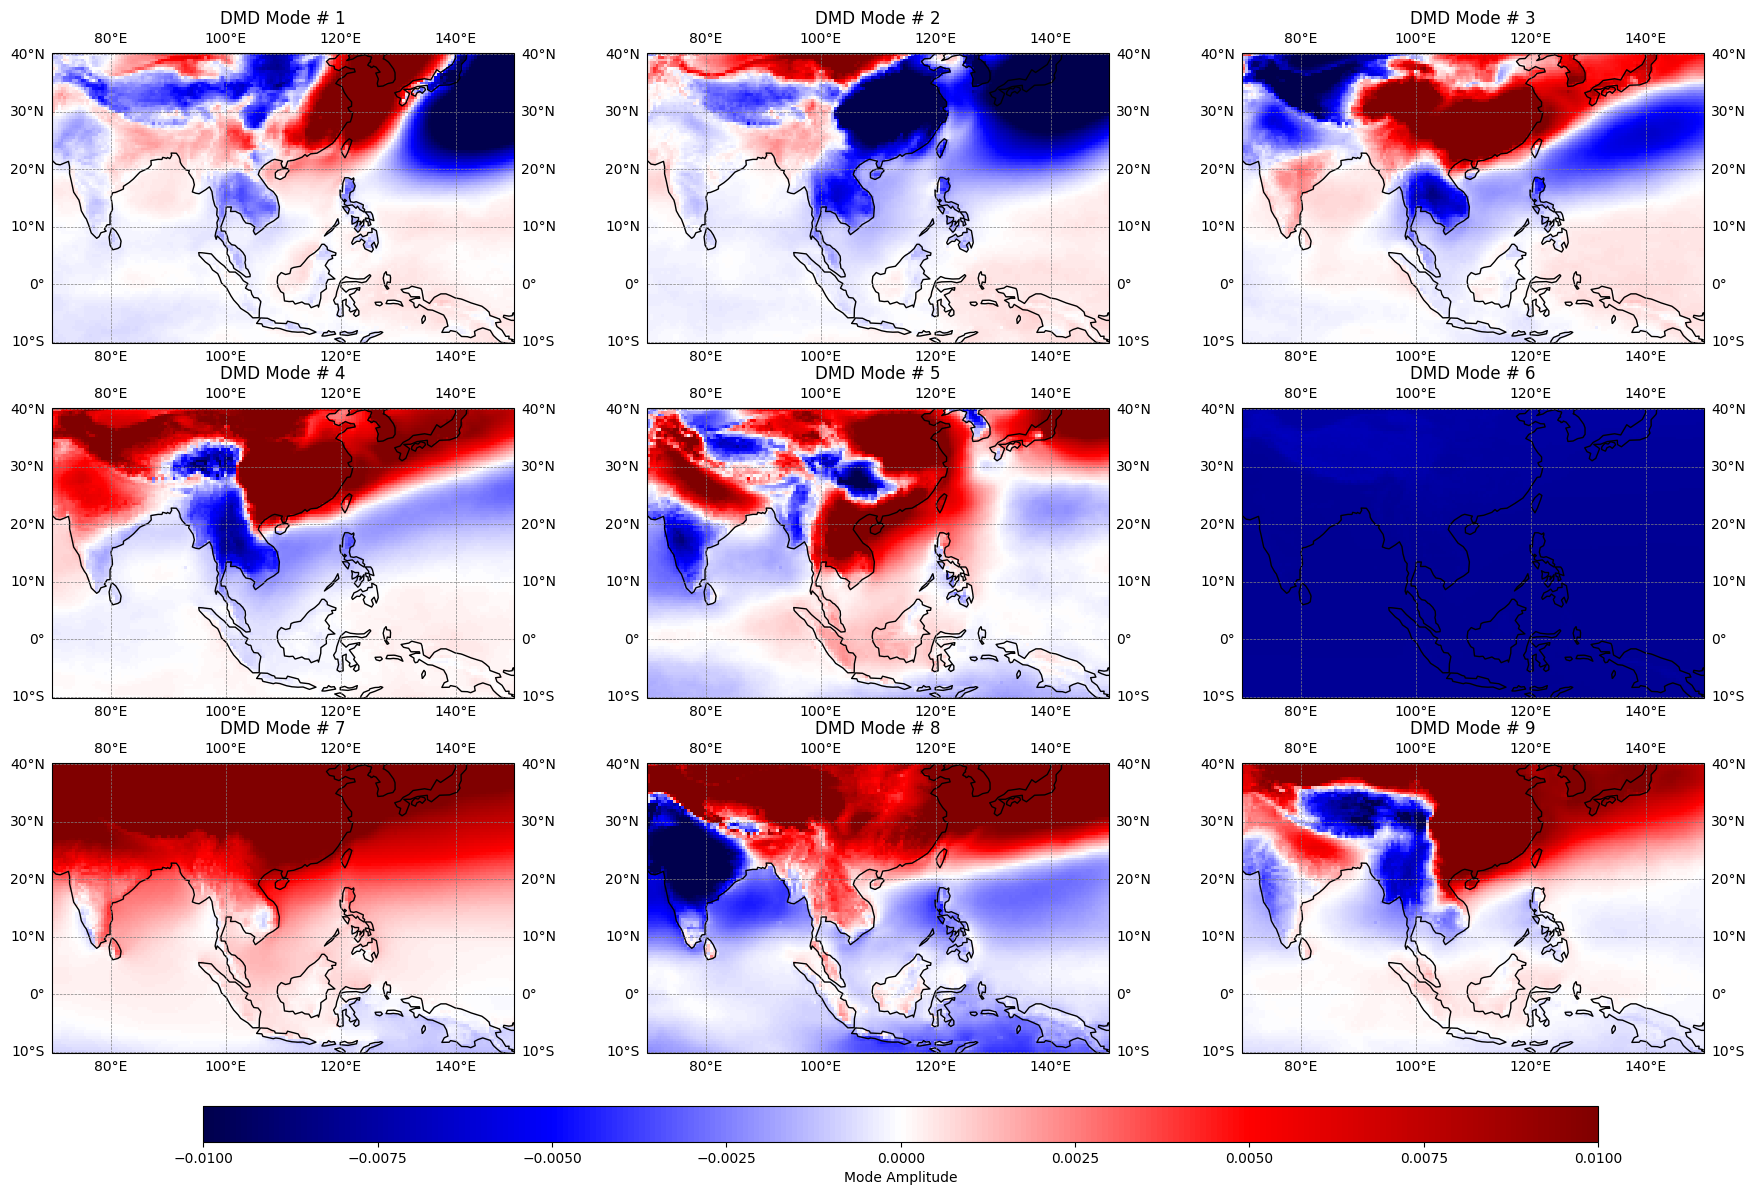

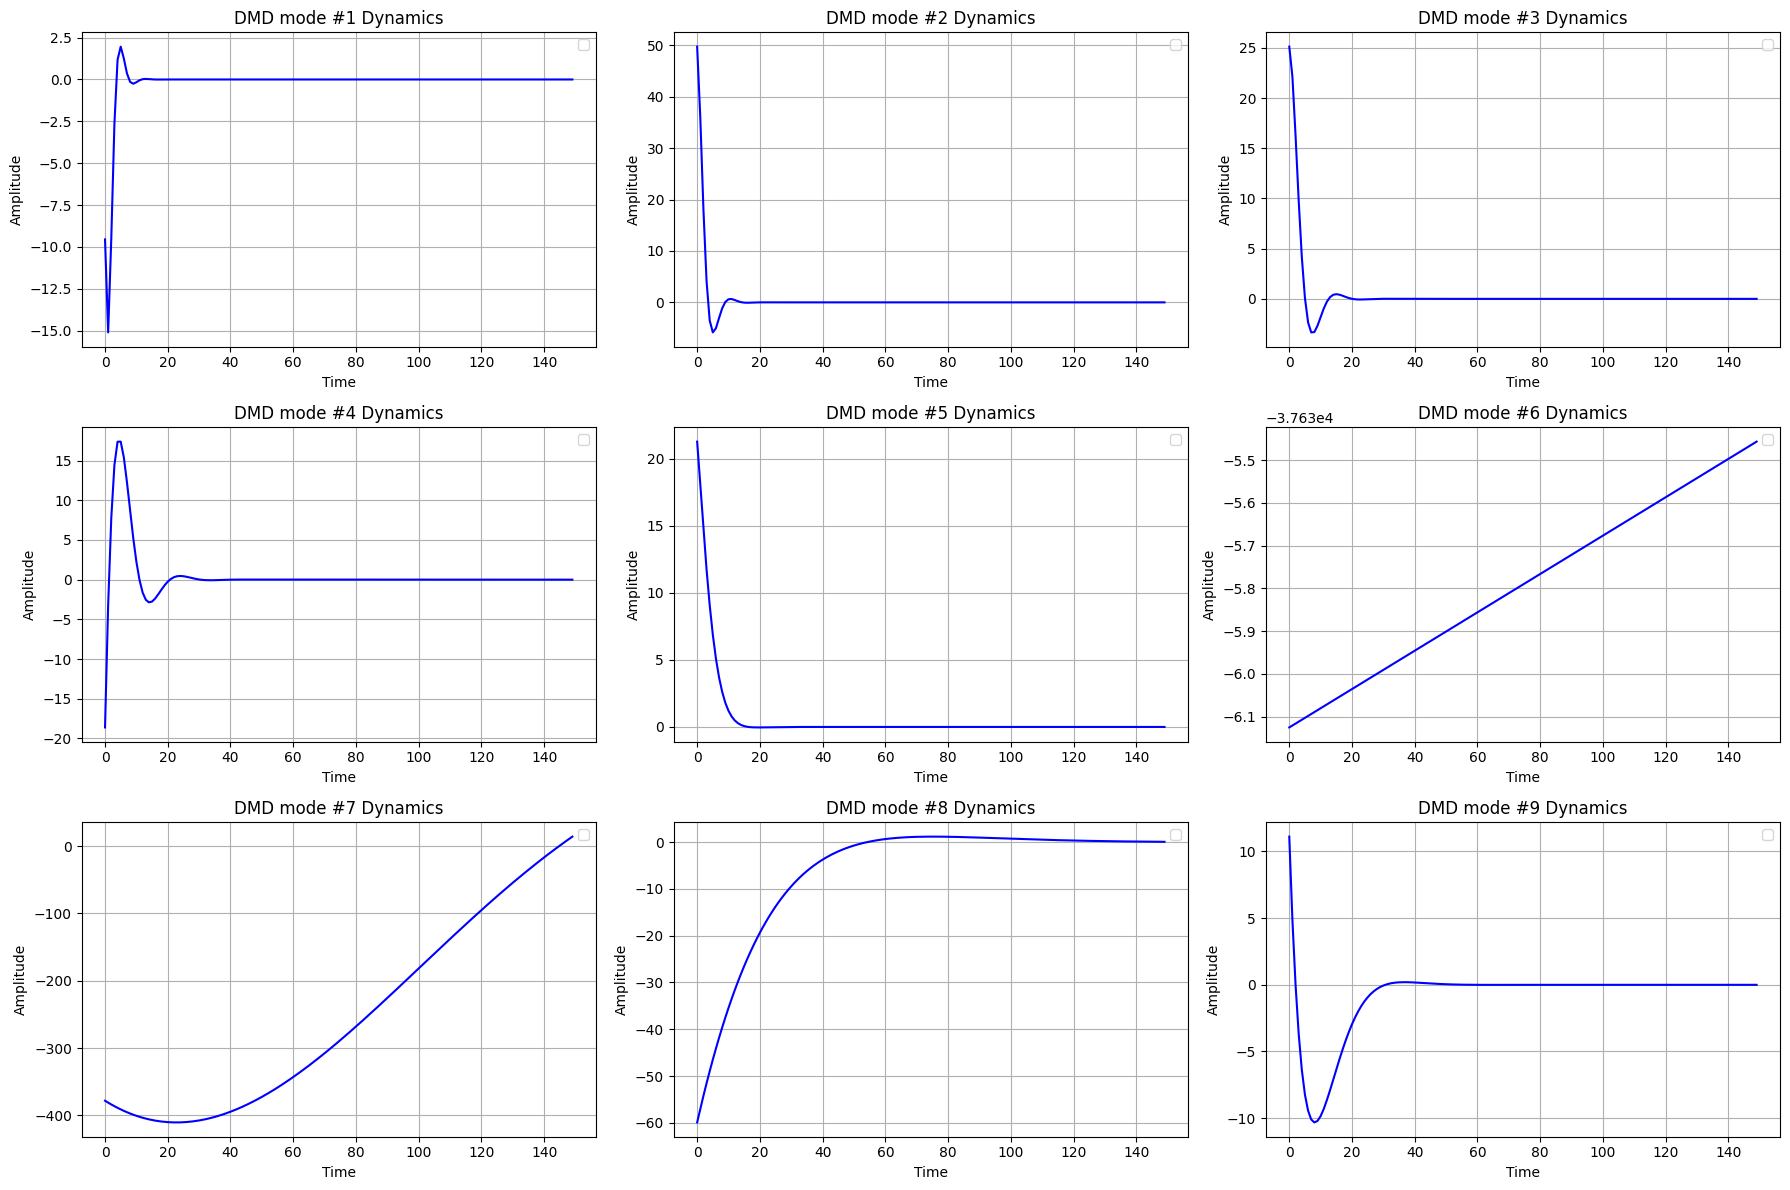

In [5]:
#plot DMD results

#Exact DMD
#plot eigenmode
plt.figure(figsize=(6, 6))
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
theta = np.linspace(0, 2 * np.pi, 200)
plt.plot(np.cos(theta), np.sin(theta), 'k--')
plt.scatter(np.real(dmd.eigs), np.imag(dmd.eigs), color='blue', label='DMD eigenvalue')
plt.xlabel('real part')
plt.ylabel('imag part')
#plt.legend() 
plt.axis('equal')
plt.grid(True)
plt.show()

#plot mode
plt.figure()
# 1-9 DMD mode
plot_mode_n = np.arange(0, 9, 1)
fig, ax = plt.subplots(3, 3, figsize=(18, 12), subplot_kw={'projection': ccrs.PlateCarree()})
# plot extent
extent = [lon.min(), lon.max(), lat.min(), lat.max()]
for i in range(3):
    for j in range(3):
       
        mode_idx = plot_mode_n [ i * 3 + j]
        mode_DMD = dmd.modes[:, 2*mode_idx]       # i th DMD mode
        mode_DMD_2d = mode_DMD.real.reshape(n_lat, n_lon)  # reshape
        
        # plot DMD mode
        im = ax[i, j].pcolormesh(lon2d, lat2d, mode_DMD_2d, shading='auto',
                    transform=ccrs.PlateCarree(), cmap='seismic',vmin=-0.01,vmax=0.01)
        
        # coastline
        ax[i, j].coastlines(resolution='110m')
        ax[i, j].add_feature(cfeature.LAND, facecolor='lightgray')
        ax[i, j].add_feature(cfeature.OCEAN, facecolor='lightblue')
        ax[i, j].gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')
        ax[i, j].set_title("DMD Mode # {}".format(mode_idx+1))

# colorbar
cbar_ax = fig.add_axes([0.125, 0.05, 0.775, 0.03])  
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', label='Mode Amplitude')
fig.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

# Plot DMD temporal dynamics
plot_mode_n = np.arange(0, 9, 1)
fig, ax = plt.subplots(3, 3, figsize=(18, 12))

n_plot = 150
timedmd = dmd.dmd_timesteps[:n_plot]
for idx, mode_idx in enumerate(plot_mode_n):
    i = idx // 3
    j = idx % 3
    
    temporal_dynamics = dmd.dynamics[2*mode_idx, :n_plot]  
    
    ax[i, j].plot(timedmd, temporal_dynamics.real, color='blue')
    ax[i, j].set_title(f"DMD mode #{mode_idx+1} Dynamics")
    ax[i, j].set_xlabel("Time")
    ax[i, j].set_ylabel("Amplitude")
    ax[i, j].grid(True)
    ax[i, j].legend()

fig.tight_layout()
plt.show()



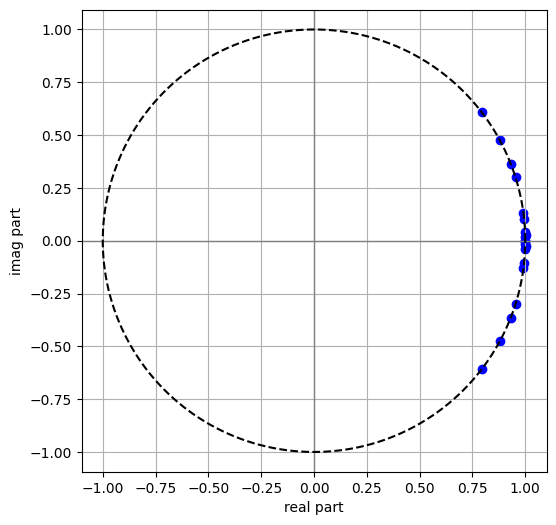

<Figure size 640x480 with 0 Axes>

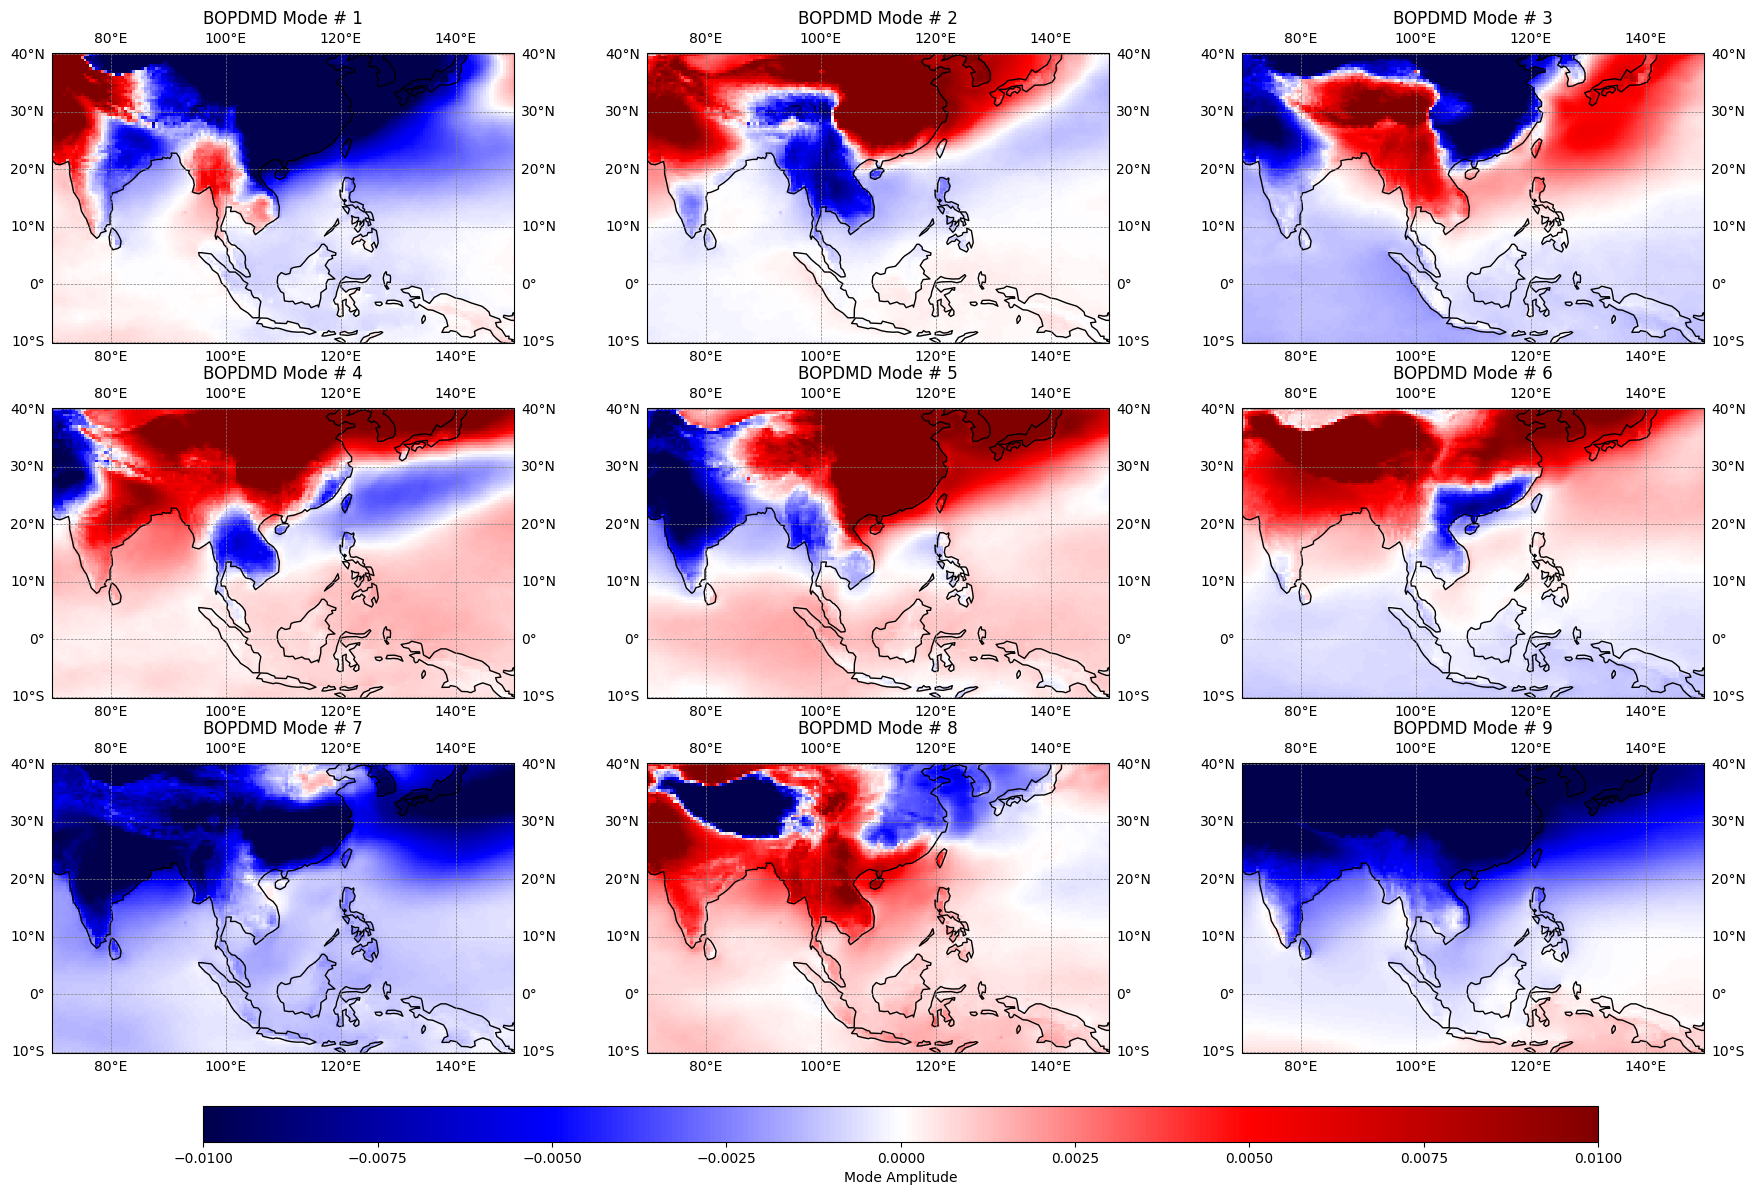

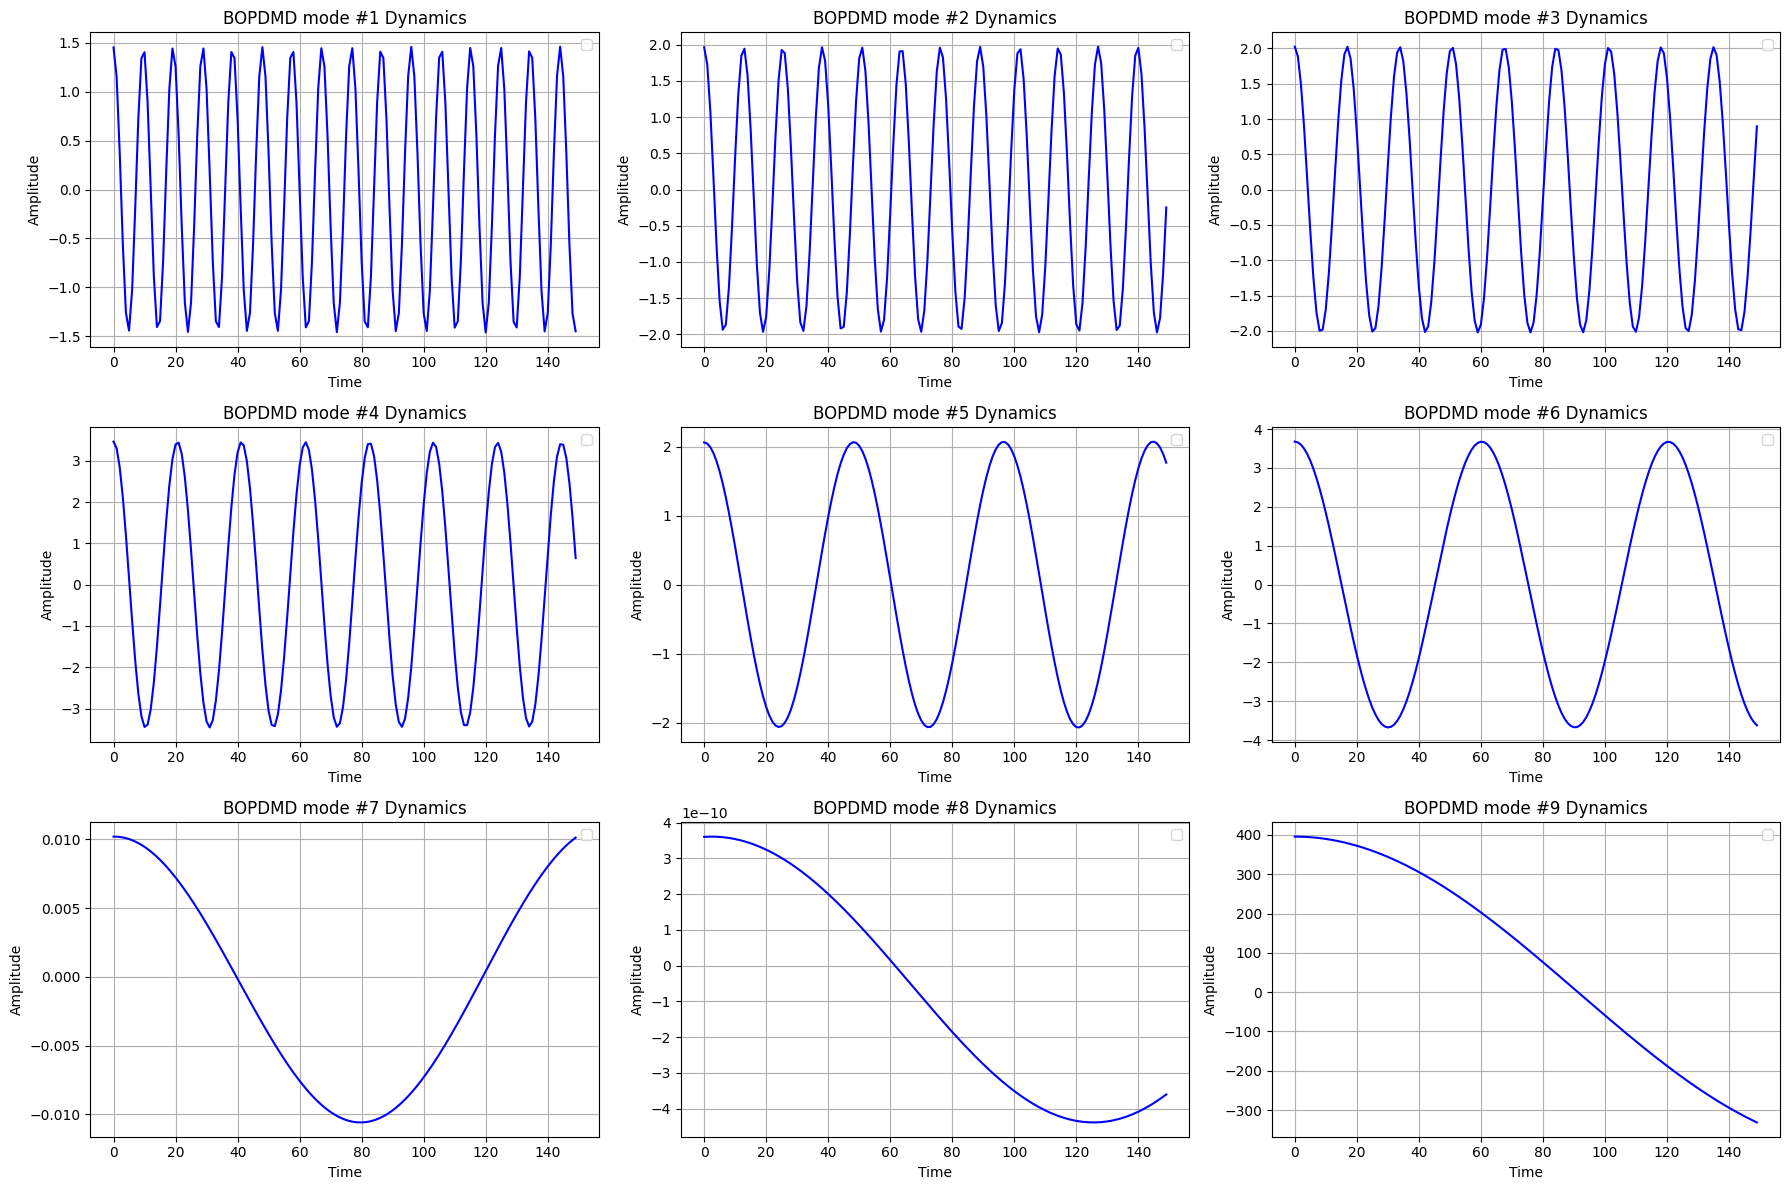

In [6]:
#plot BOPDMD results

#BOP DMD
#plot eigenmode
dt = 1
lambdas = np.exp(BOPdmd.eigs * dt)  #BOP DMD gives eigenvalue for continous system--> transfer to discretized system
plt.figure(figsize=(6, 6))
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
theta = np.linspace(0, 2 * np.pi, 200)
plt.plot(np.cos(theta), np.sin(theta), 'k--')
plt.scatter(np.real(lambdas), np.imag(lambdas), color='blue', label='BOPDMD eigenvalue')
plt.xlabel('real part')
plt.ylabel('imag part')
#plt.legend() 
plt.axis('equal')
plt.grid(True)
plt.show()

#plot mode
plt.figure()
# 1-9 BOPDMD mode
plot_mode_n = np.arange(0, 9, 1)
fig, ax = plt.subplots(3, 3, figsize=(18, 12), subplot_kw={'projection': ccrs.PlateCarree()})
# plot extent
extent = [lon.min(), lon.max(), lat.min(), lat.max()]
for i in range(3):
    for j in range(3):
       
        mode_idx = plot_mode_n [ i * 3 + j]
        BOPmode_DMD = BOPdmd.modes[:, 2*mode_idx]       # i th DMD mode
        BOPmode_DMD_2d = BOPmode_DMD.real.reshape(n_lat, n_lon)  # reshape
        
        # plot DMD mode
        im = ax[i, j].pcolormesh(lon2d, lat2d, BOPmode_DMD_2d, shading='auto',
                    transform=ccrs.PlateCarree(), cmap='seismic',vmin=-0.01,vmax=0.01)
        
        # coastline
        ax[i, j].coastlines(resolution='110m')
        ax[i, j].add_feature(cfeature.LAND, facecolor='lightgray')
        ax[i, j].add_feature(cfeature.OCEAN, facecolor='lightblue')
        ax[i, j].gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')
        ax[i, j].set_title("BOPDMD Mode # {}".format(mode_idx+1))

# colorbar
cbar_ax = fig.add_axes([0.125, 0.05, 0.775, 0.03])  
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', label='Mode Amplitude')
fig.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()


# Plot BOPDMD temporal dynamics
plot_mode_n = np.arange(0, 9, 1)
fig, ax = plt.subplots(3, 3, figsize=(18, 12))

n_plot = 150
timedmd = dmd.dmd_timesteps[:n_plot]
for idx, mode_idx in enumerate(plot_mode_n):
    i = idx // 3
    j = idx % 3
    
    temporal_dynamics = BOPdmd.dynamics[2*mode_idx, :n_plot]  
    
    ax[i, j].plot(timedmd, temporal_dynamics.real, color='blue')
    ax[i, j].set_title(f"BOPDMD mode #{mode_idx+1} Dynamics")
    ax[i, j].set_xlabel("Time")
    ax[i, j].set_ylabel("Amplitude")
    ax[i, j].grid(True)
    ax[i, j].legend()

fig.tight_layout()
plt.show()


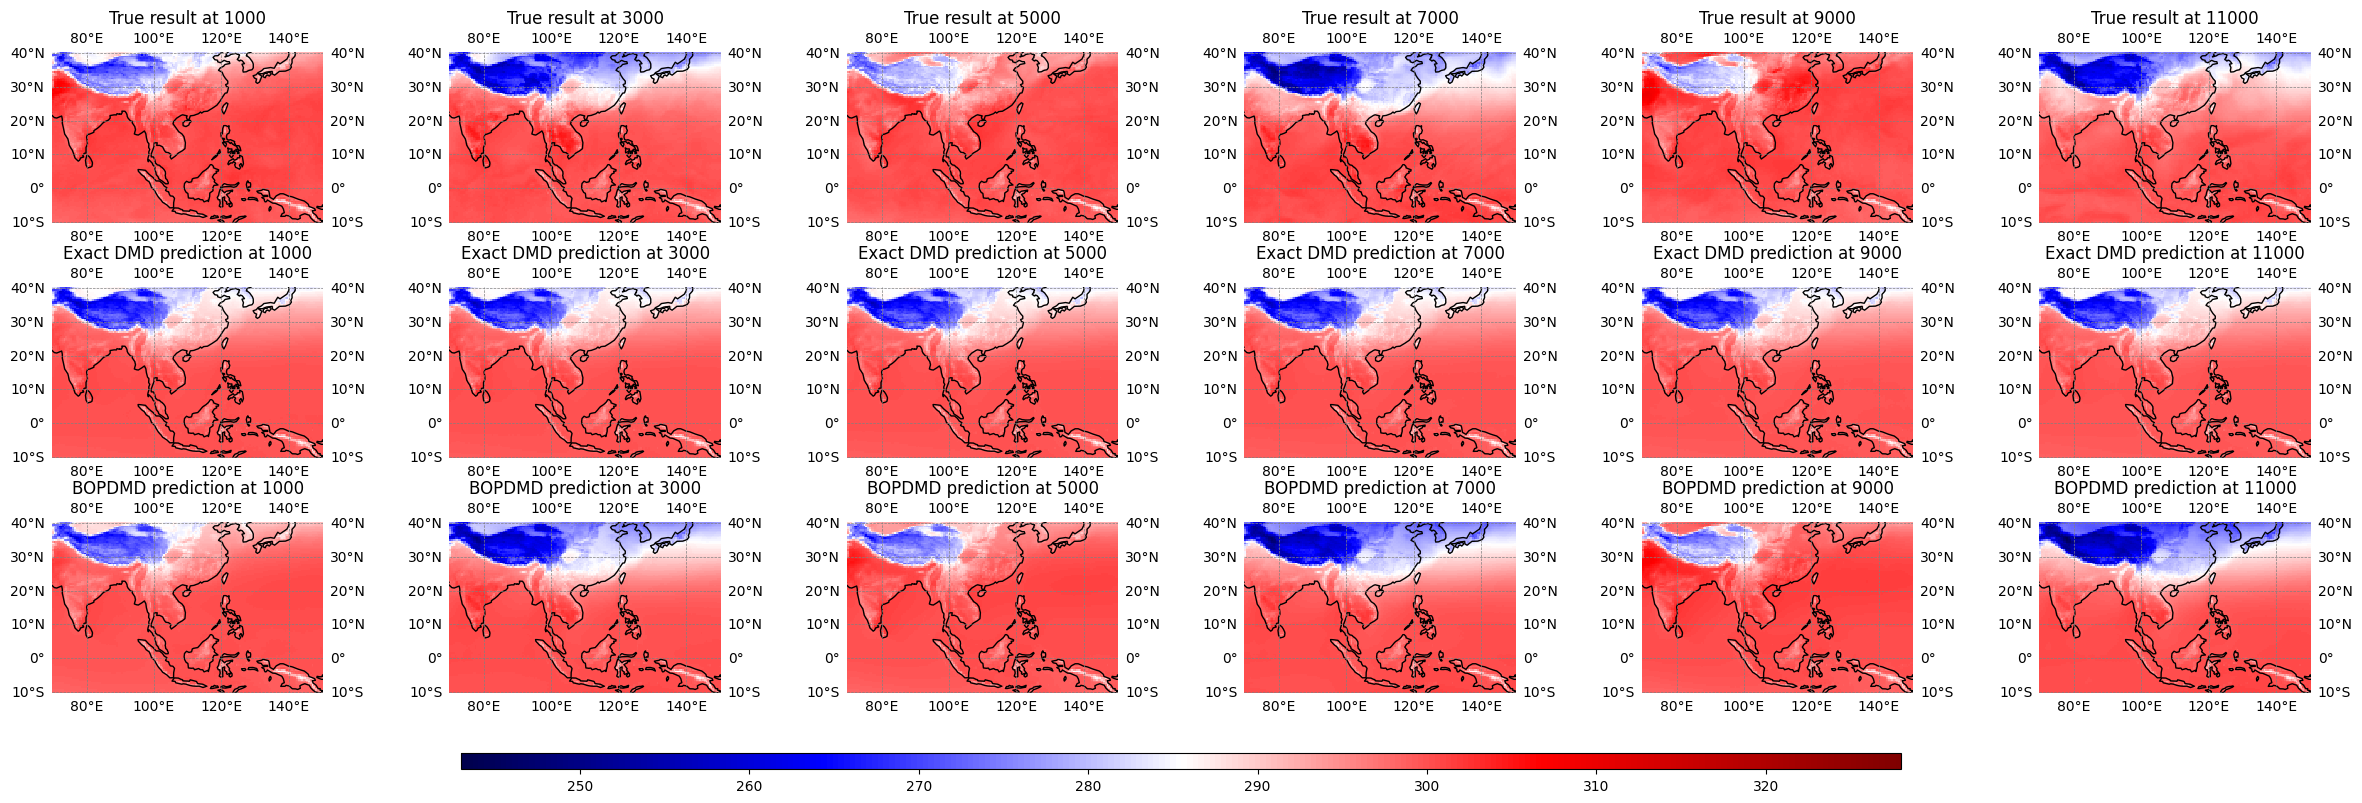

In [7]:
X_true = Xt2m[:, :-1]
X_rec = dmd.reconstructed_data.real
BOPX_rec = BOPdmd.reconstructed_data.real

# compare
indices = [1000,3000,5000,7000,9000,11000]
fig, axes = plt.subplots(3, len(indices), 
                         figsize=(4 * len(indices), 8),
                         subplot_kw={'projection': ccrs.PlateCarree()})

for row in range(3):  # 0: true, 1: reconstructed Exact DMD, 2: reconstructed BOP DMD
    for col in range(len(indices)):
            
        idx = indices[col]

        if row == 0 :
            field = X_true[:, idx] 
        elif row == 1 :
            field = X_rec[:, idx]
        else :
            field = BOPX_rec[:, idx]
        #reshape
        field = field.reshape(n_lat, n_lon)  # reshape
        
        #plot fields for ture\prediction results
        ax = axes[row, col]
        im = ax.pcolormesh(lon2d, lat2d, field, shading='auto',
                    transform=ccrs.PlateCarree(), cmap='seismic',vmin=-30+273,vmax=55+273)
        
        # coastline
        ax.coastlines(resolution='110m')
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
        ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')
            
        ax.axis('off')

        if row == 0:
            ax.set_title(f"True result at {idx}")
        elif row == 1 :
            ax.set_title(f"Exact DMD prediction at {idx}")           
        else :            
            ax.set_title(f"BOPDMD prediction at {idx}")
           
# Add a single shared colorbar
# Reserve more space at the bottom
plt.tight_layout(rect=[0, 0.1, 1, 1])  # top-left:0, bottom:0.15
    
# Add colorbar below figure, outside subplots
cbar_ax = fig.add_axes([0.2, 0.04, 0.6, 0.02])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    
plt.show()

In [8]:
import pickle

# save exact DMD
with open('DMD_results/Exact_DMD_t2m.pkl', 'wb') as f:
    pickle.dump(dmd, f)

print("Exact DMD saved into DMD_results/Exact_DMD_t2m.pkl")

# save BOPDMD
with open('DMD_results/BOP_DMD_t2m.pkl', 'wb') as f:
    pickle.dump(BOPdmd, f)

print("BOPDMD saved into DMD_results/BOP_DMD_t2m.pkl")

Exact DMD saved into DMD_results/Exact_DMD_t2m.pkl
BOPDMD saved into DMD_results/BOP_DMD_t2m.pkl
